# Analysing UKRI IP Outcomes

### Project Overview
This analysis explores intellectual property (IP) outcomes from UK Research and Innovation (UKRI) funded projects to identify patterns in patent licensing success across different research domains.

### Key Question
- Which research fields produce the most licensed patents?
- Which research fields are most successful with their patent applications?

### Data Source
- Gateway to Research API (UKRI)
- Dataset: ~5,400 IP outcome records with patent information

### Methods
- Text embeddings using Sentence Transformers (AllenAI-SPECTER model)
- Dimensionality reduction comparison: PCA, t-SNE, UMAP
- K-means clustering for research domain identification
- LLM-based cluster labelling via Hugging Face Inference API

### Key Findings

- **Nucleic acid technologies**, **Computer Vision**, and **Energy Materials** see the highest number of patents applied for, at over **310 each**

- Amongst the top five most patented fields, **Regenerative Medicine** sees the highest success rate with ~35% of patents being accepted

- The majority of patents are funded by **EPSRC**, **BBSRC,** or **MRC**

![](umap_plot.png)

### 1. Data Loading and Initial Exploration

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

plt.rcParams['figure.dpi'] = 300

config = {
    'toImageButtonOptions': {
        'scale':2.2
    }
}

In [92]:
df = pd.read_csv('ip_search.csv')
df.columns

Index(['Funding OrgName', 'Project Reference', 'ProjectCategory',
       'Outcome Type', 'LeadRO Name', 'Department', 'PI Surname',
       'PI First Name', 'PI Orcid iD', 'Outcome Title', 'Description',
       'Protection', 'IP Reference', 'Year Protection Granted', 'Licensed?',
       'Impact', 'Url', 'GTR OutcomeId', 'GTR Outcome URL', 'GTRProjectUrl',
       'ProjectId', 'FundingOrgId', 'LeadROId', 'PIId'],
      dtype='str')

### 2. Filtering for Patents and Exploratory Data Analysis

In [93]:
df['Protection'].value_counts()

Protection
Patent application published    2832
Patent granted                  1369
Patent / Patent application     1230
Copyrighted (e.g. software)      333
Protection not required          332
Trade Mark                       187
Protection Not Required            1
Name: count, dtype: int64

Licensed?
No                          3316
Commercial In Confidence    1064
Yes                         1051
Name: count, dtype: int64


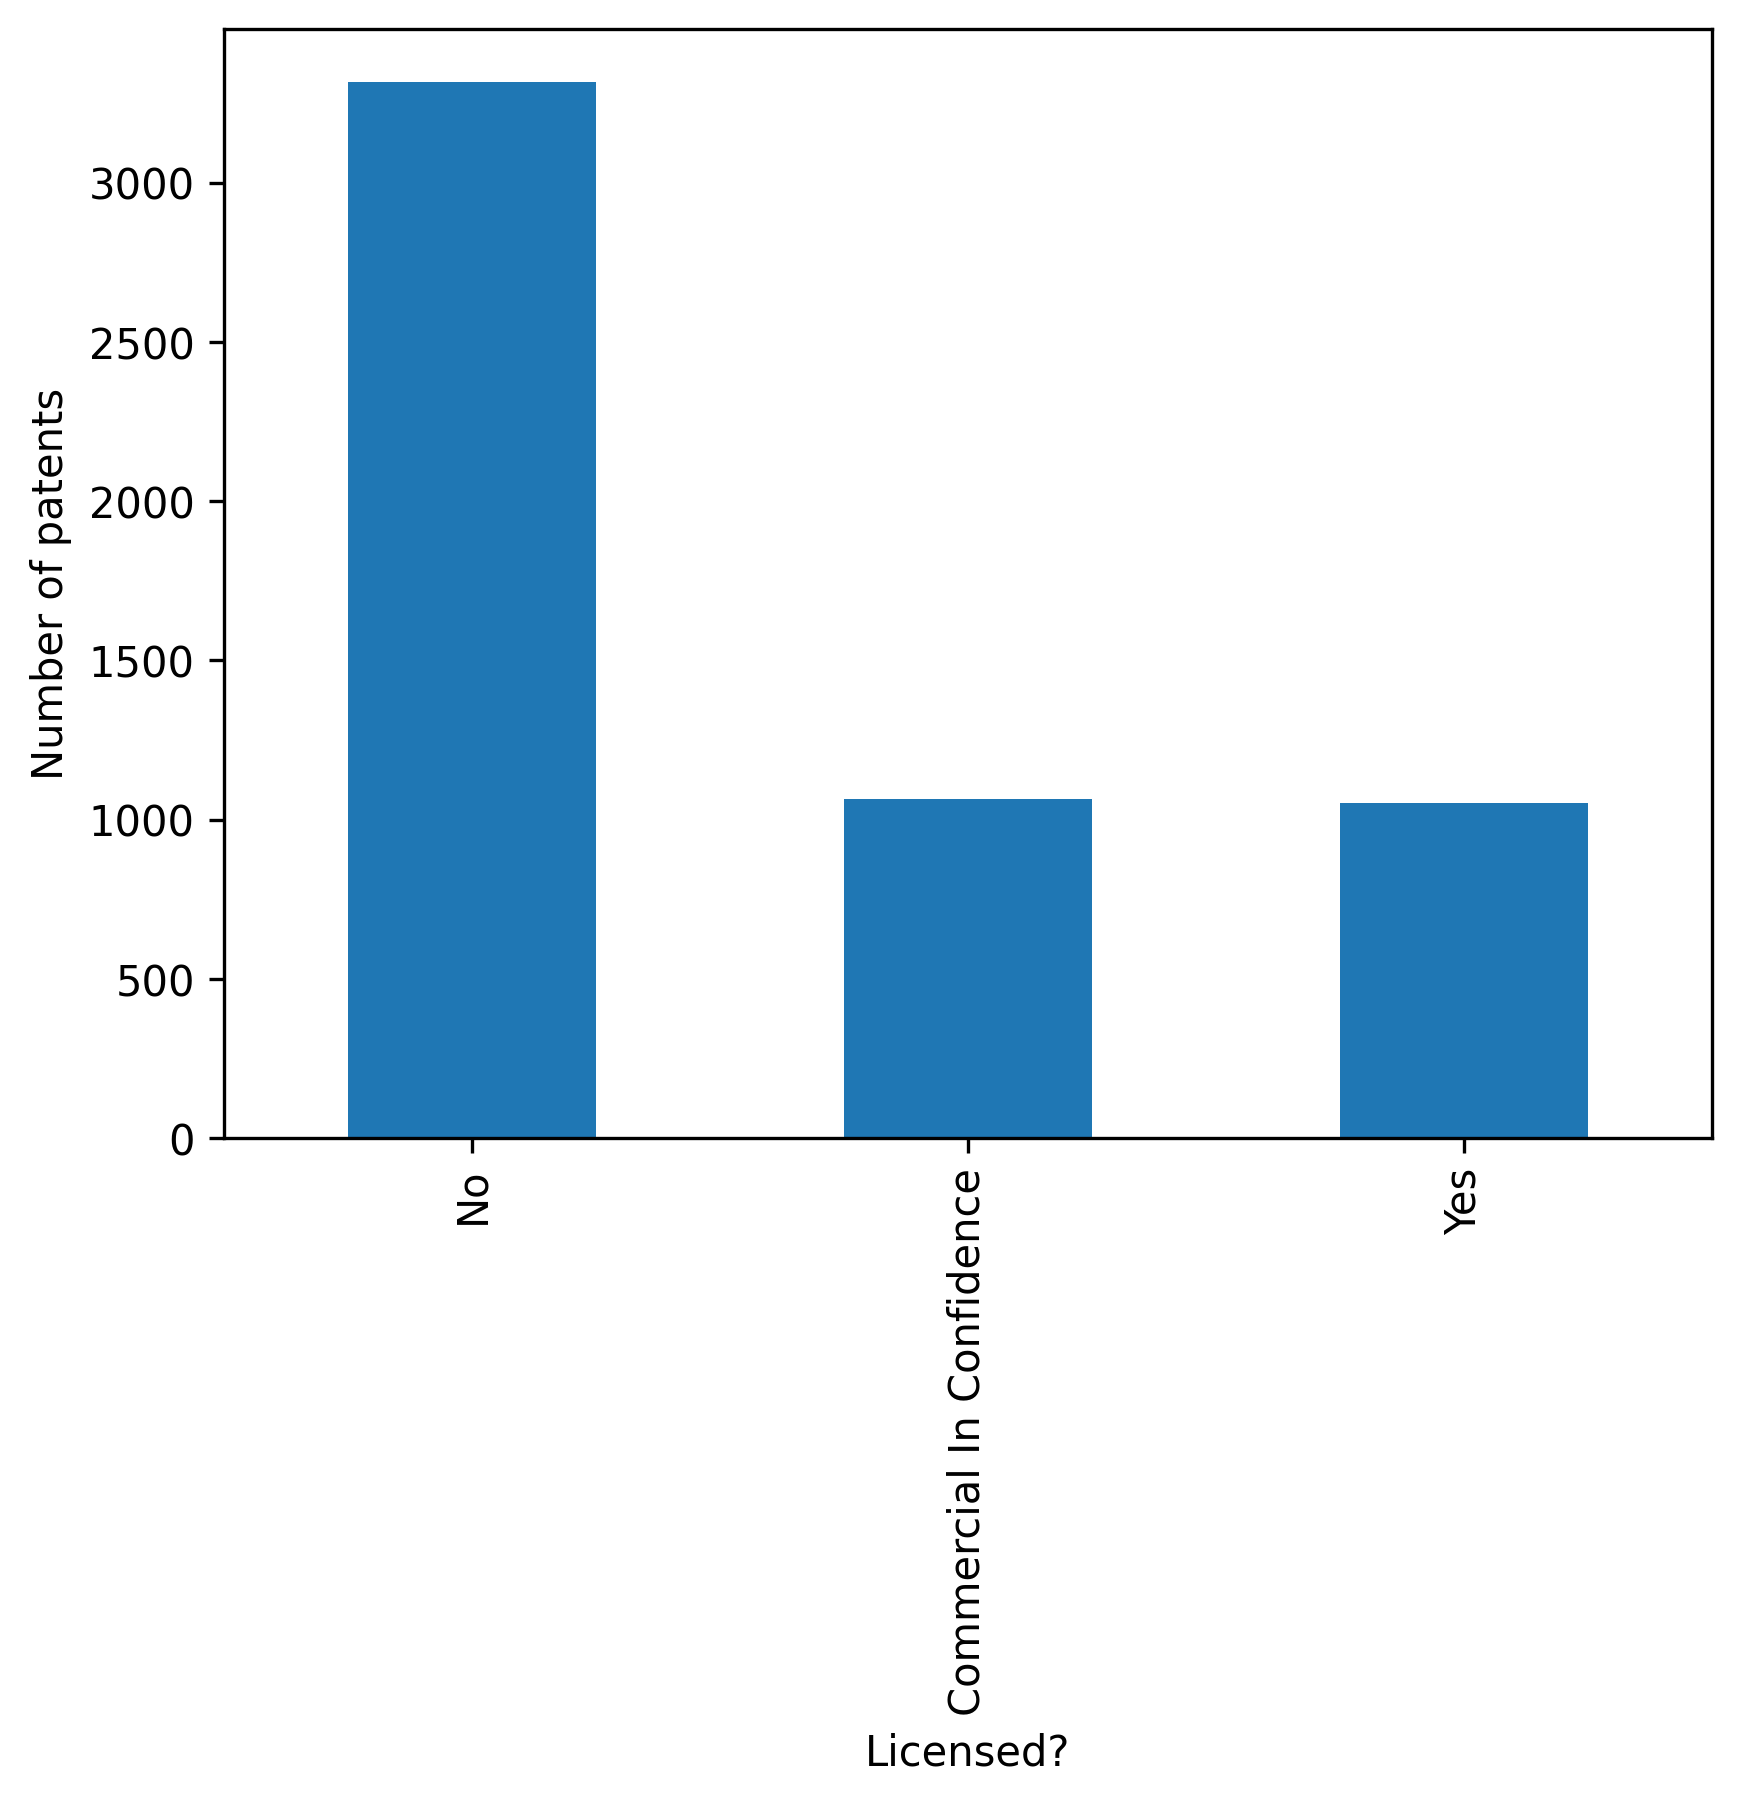

In [94]:
patent_values = ['Patent application published','Patent granted', 'Patent / Patent application']
df = df[df['Protection'].isin(patent_values)]

print(df['Licensed?'].value_counts())

df['Licensed?'].value_counts().plot(kind='bar')
plt.ylabel('Number of patents')
plt.show()

The 'Commercial In Confidence' value simply refers to the patent status not being stated. These can be dropped for the clustering analysis.

Next we can see how different funding organisations contribute to IP: 

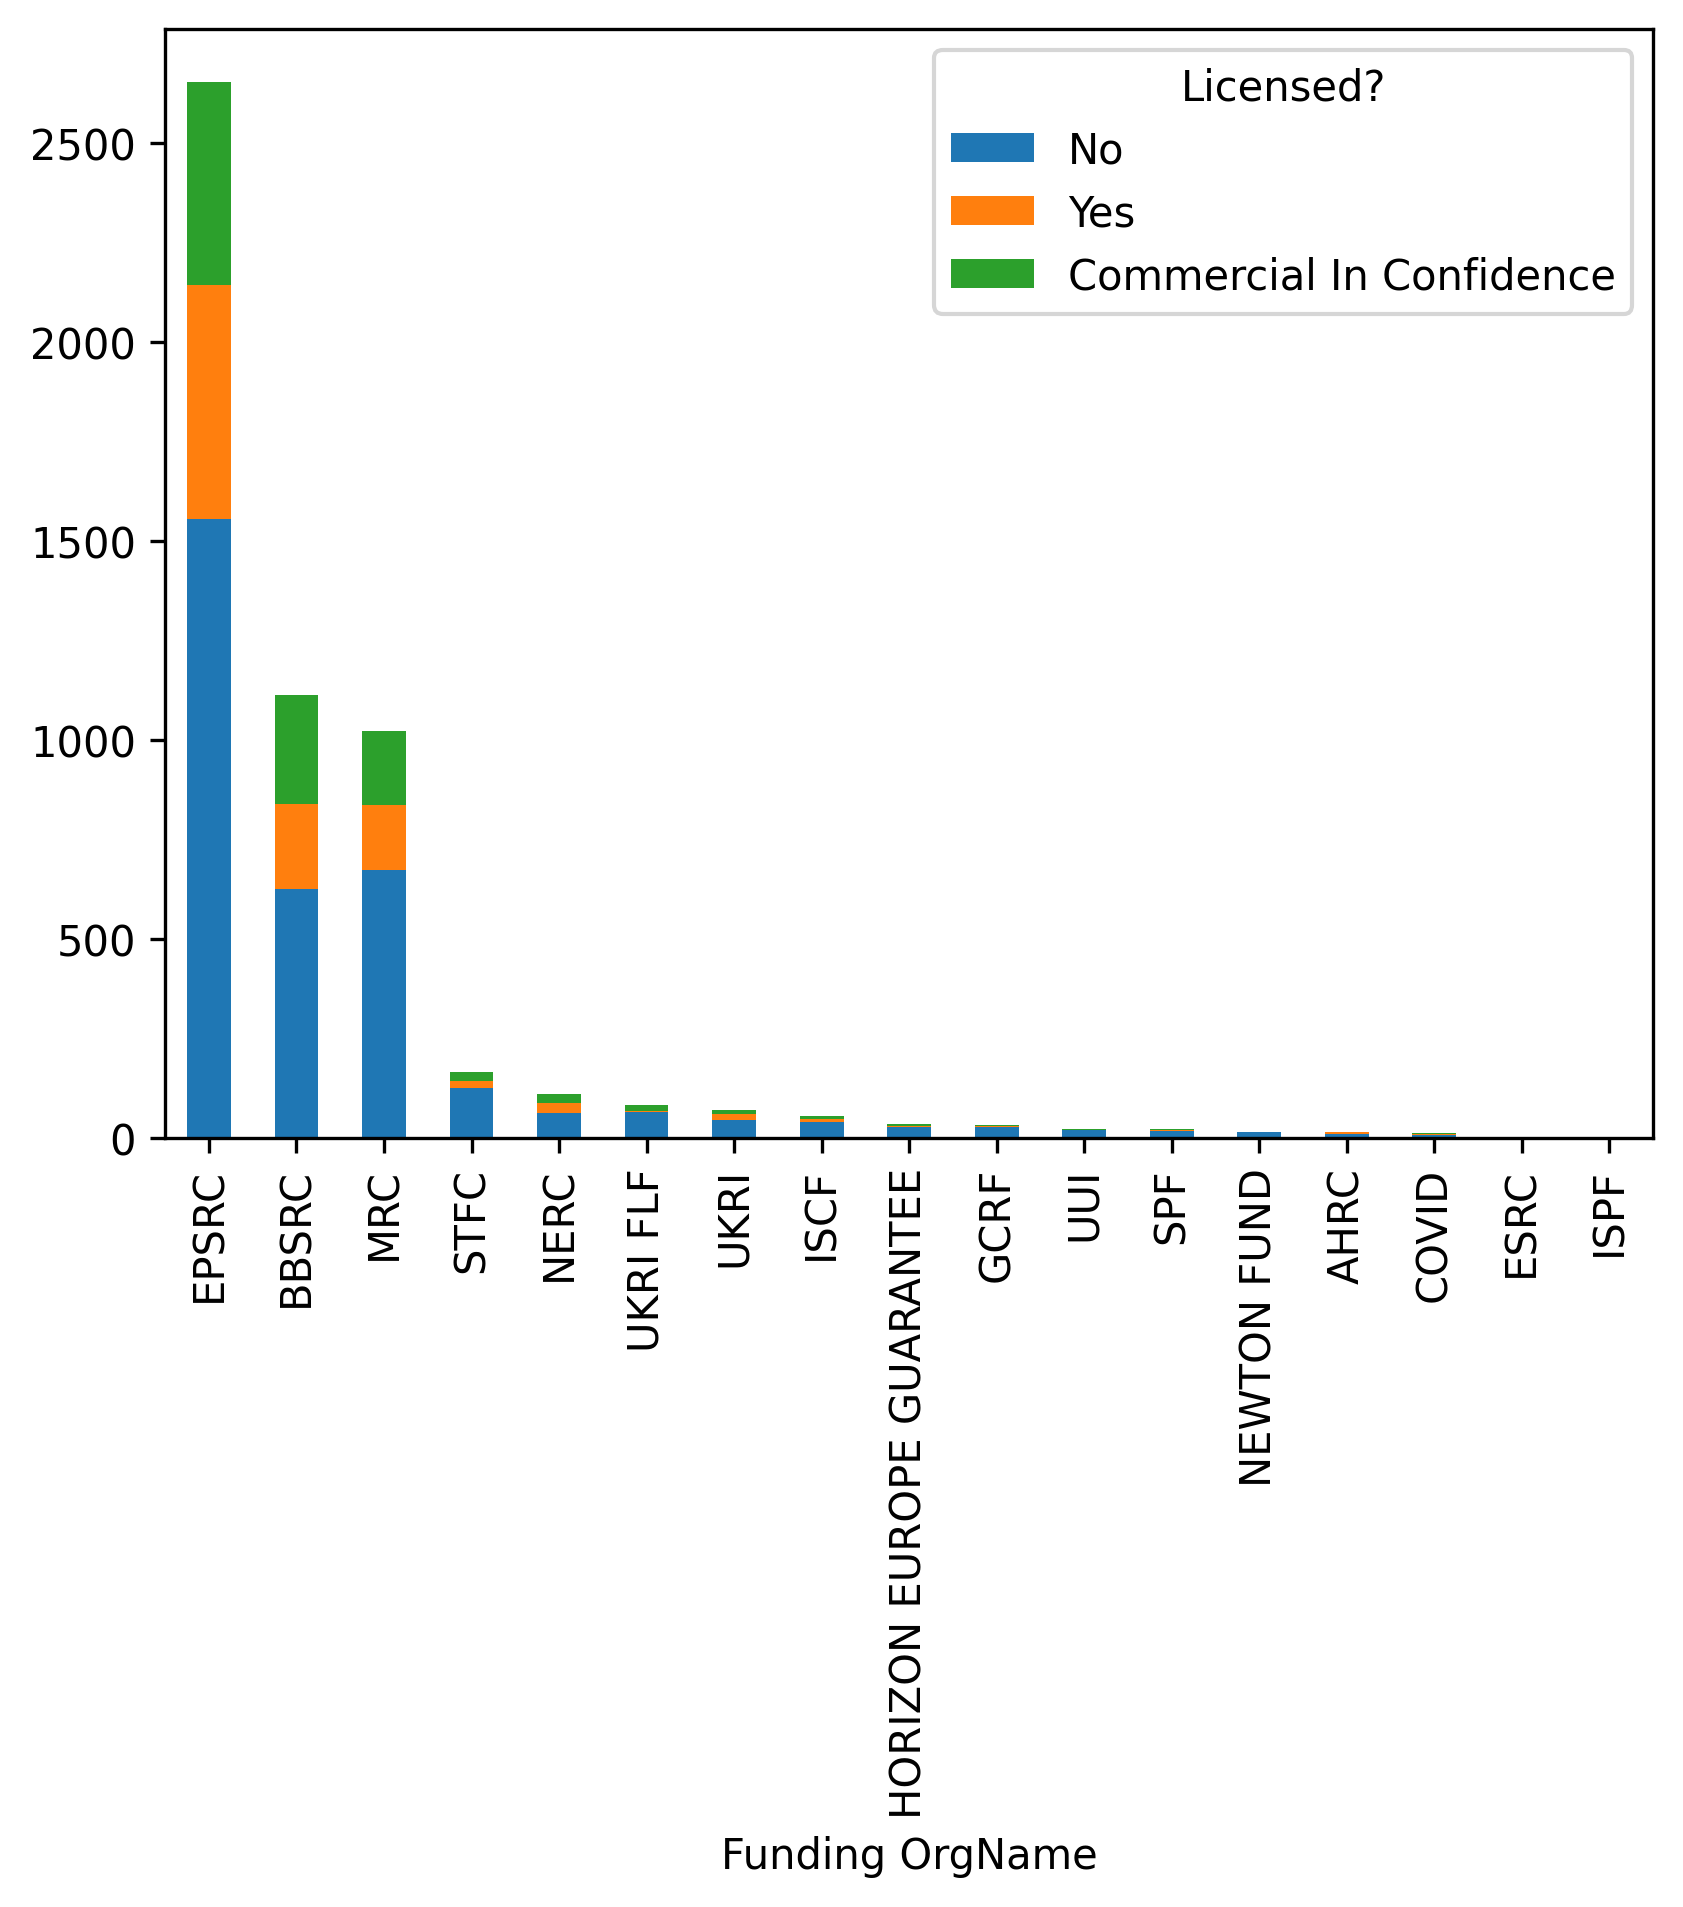

In [95]:
def get_unstacked(df,category):
    df = df.copy()
    unstacked_df = df.groupby(category)['Licensed?'].value_counts().unstack(fill_value=0)
    unstacked_df['Total'] = unstacked_df.sum(axis=1)
    sorted_df = unstacked_df.sort_values('Total',ascending=False)
    return sorted_df

funding_org_groups = get_unstacked(df,'Funding OrgName')
funding_org_groups[['No','Yes','Commercial In Confidence']].plot(kind='bar',stacked=True)
plt.show()

Now by PI:

In [96]:
df['PI Name'] = df['PI First Name'] + " " + df['PI Surname']
get_unstacked(df,'PI Name').head(10)

Licensed?,Commercial In Confidence,No,Yes,Total
PI Name,,,,
Andrea Ferrari,50,17,2,69
John Fisher,4,24,35,63
Lord Robert Mair,0,48,2,50
Harish Bhaskaran,0,42,0,42
Steven Rannard,3,22,15,40
Matt Mowlem,18,17,4,39
Anthony Kucernak,0,0,31,31
Stephen Ward,11,15,5,31
Matthew Wood,9,12,9,30


Next, department:

In [97]:
get_unstacked(df,'Department').head(10)

Licensed?,Commercial In Confidence,No,Yes,Total
Department,,,,
UNLISTED,225,512,112,849
Chemistry,62,213,146,421
Engineering,87,123,22,232
Materials,12,95,20,127
Electronic and Electrical Engineering,28,85,12,125
Physics,33,71,14,118
Mechanical Engineering,11,56,45,112
Sch of Engineering,7,78,15,100
Engineering Science,14,28,39,81


A lot of departments are 'UNLISTED'. Perhaps our clustering analysis can determine more information about these.

### 3. Text Preprocessing
The clustering analysis will utilise the title and description fields, which contain the most semantic information. To performs analysis, we will remove nulls and check the lengths of strings.

In [98]:
print(len(df))
print(df['Description'].isnull().sum())
print(df['Outcome Title'].isnull().sum())

5431
45
1


It is unfeasible to work with descriptions that are null so these can be dropped.

In [99]:
df = df.dropna(subset=['Description','Outcome Title'])
df['Title_Description'] = df['Outcome Title'] + ': ' + df['Description']
len(df)

5386

Next, we can check the distribution of Title_Description lengths:

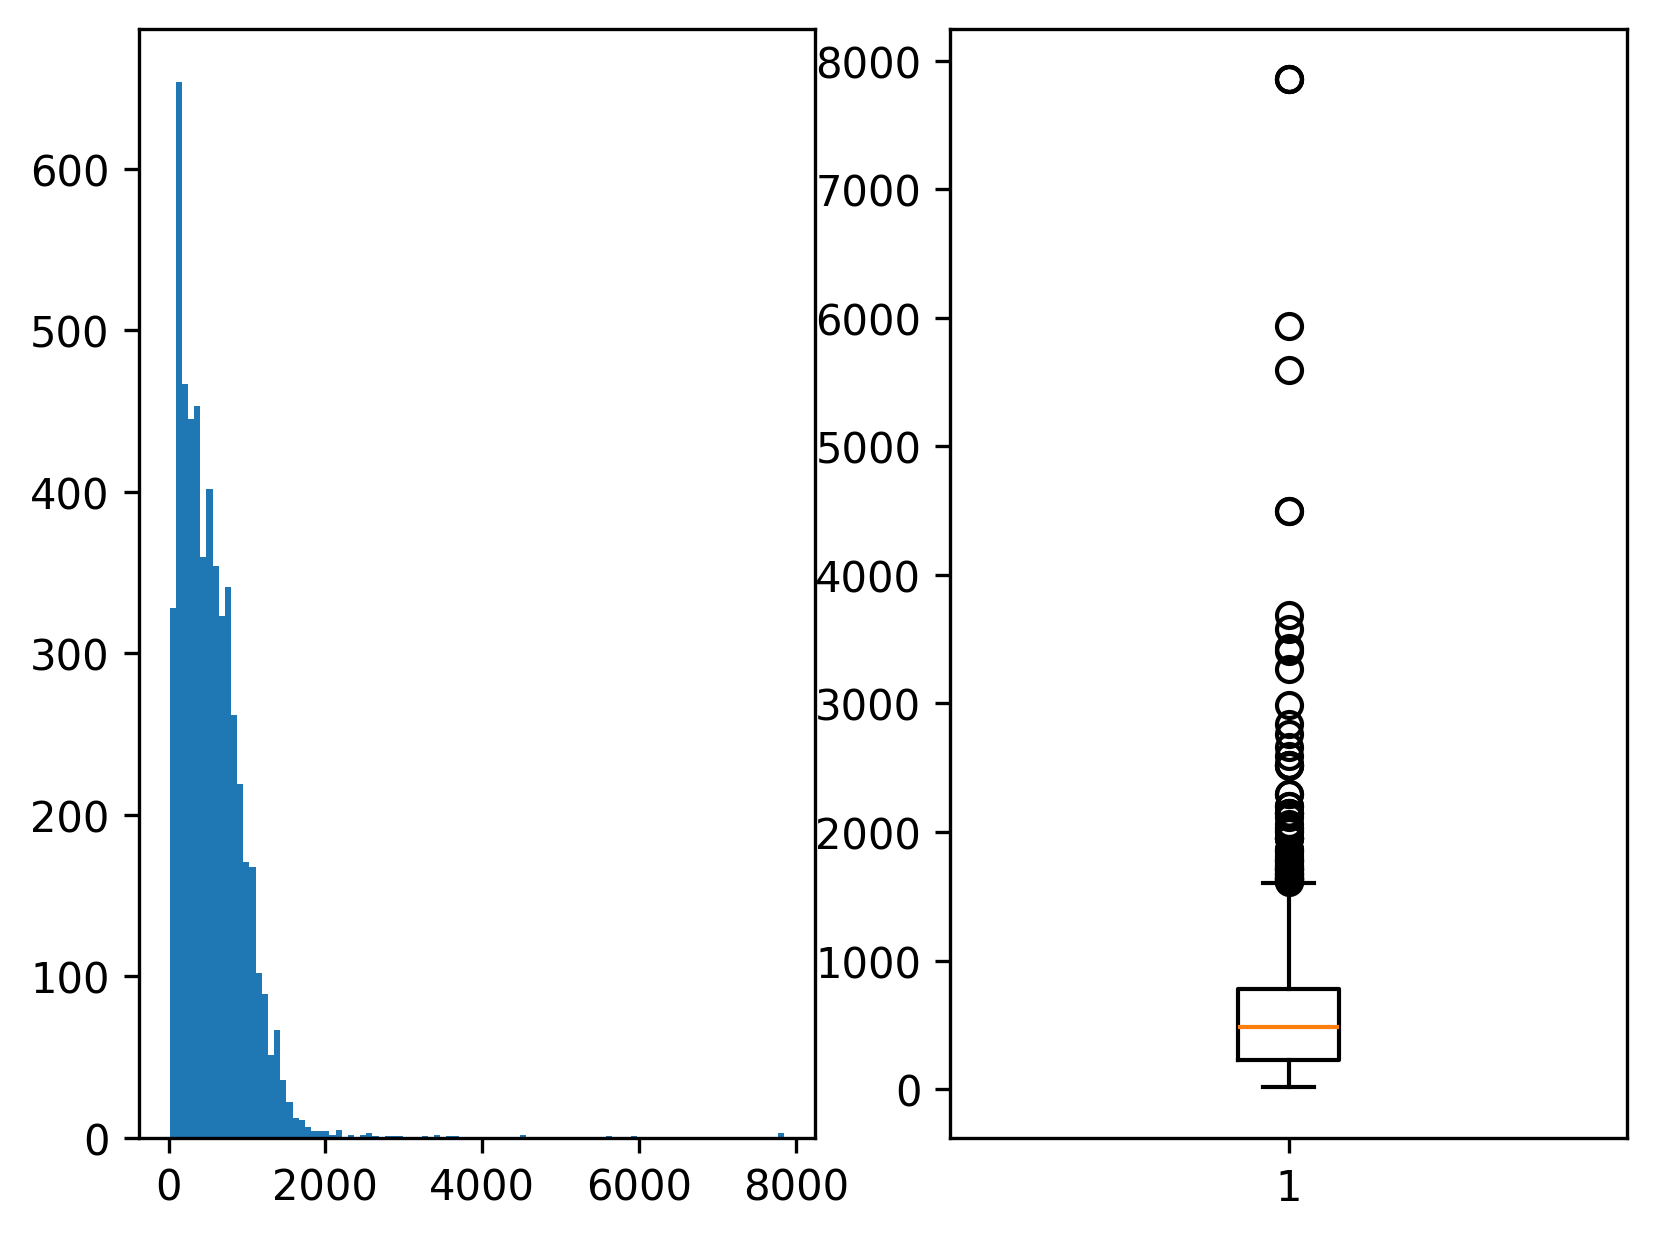

In [100]:
string_length = pd.DataFrame()
string_length['string'] = df['Title_Description']
string_length['length'] = string_length['string'].apply(lambda x: len(x))

fig, ax = plt.subplots(1,2)

ax[0].hist(x=string_length['length'],bins=100)
ax[1].boxplot(string_length['length'])
plt.show()

A lot of strings are uneccessarily long, which will slow down embedding without providing more information. There are also a lot of strings that are very short and won't provide enough information, these should be removed.

In [101]:
too_short = string_length['length'] < 80
print(string_length[too_short].sort_values('length',ascending=True)['string'].head(20))
print()
print(len(too_short))
print()
print(too_short.value_counts().head(10))

998                                  ?????SVG??: /
3706                                Patent: Patent
3728                        Permipatch: Permipatch
3251                    Confidential: Confidential
2213                    Confidential: Confidential
2297                    Confidential: Confidential
1363                    Confidential: Confidential
496                     Confidential: Confidential
422                     Confidential: Confidential
1202                    Confidential: Confidential
4955                    Confidential: Confidential
5993                    Confidential: Confidential
5028                    Confidential: Confidential
5387                    Confidential: Confidential
4736                    Confidential: Confidential
5446                    Confidential: Confidential
5124              Optical Fibre Lasers: commercial
997            ????????LCC-HVDC????????????????: /
5654         Resetting pluripotent stem cells: n.a
414     Process: New interative

In [102]:
string_length = string_length[string_length['length'] >= 80]

too_long = string_length['length'] > 3000
string_length[too_long]['length'].value_counts()

length
7855    3
5935    1
3691    1
3583    1
4494    1
5596    1
4496    1
3428    1
3408    1
3267    1
Name: count, dtype: int64

We can crop strings to a maximum of 3000 characters, to remove some of the lengthier strings.

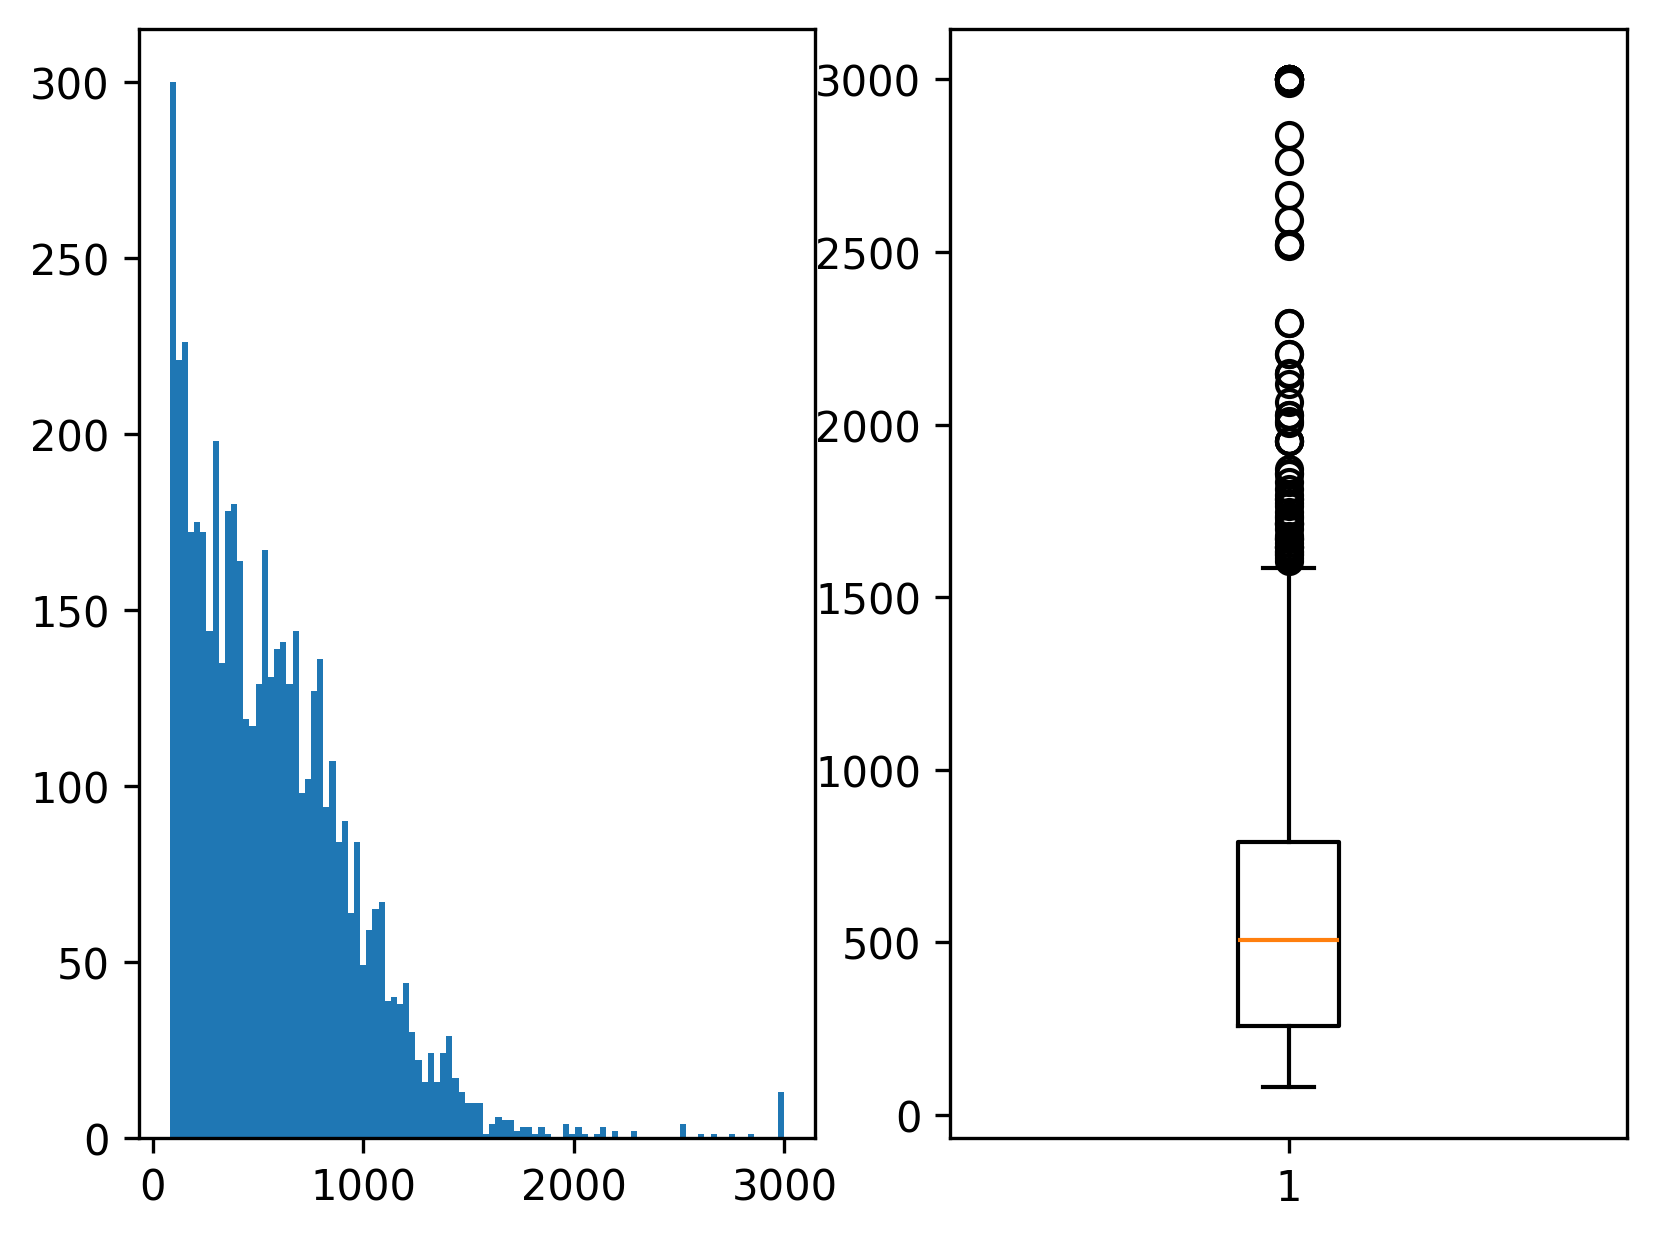

5161


In [103]:
string_length['string_cropped']  = string_length['string'].apply(lambda x: x[:3000])
string_length['length_cropped'] = string_length['string_cropped'].apply(lambda x: len(x))

fig, ax = plt.subplots(1,2)

ax[0].hist(x=string_length['length_cropped'],bins=100)
ax[1].boxplot(string_length['length_cropped'])
plt.show()
print(len(string_length))

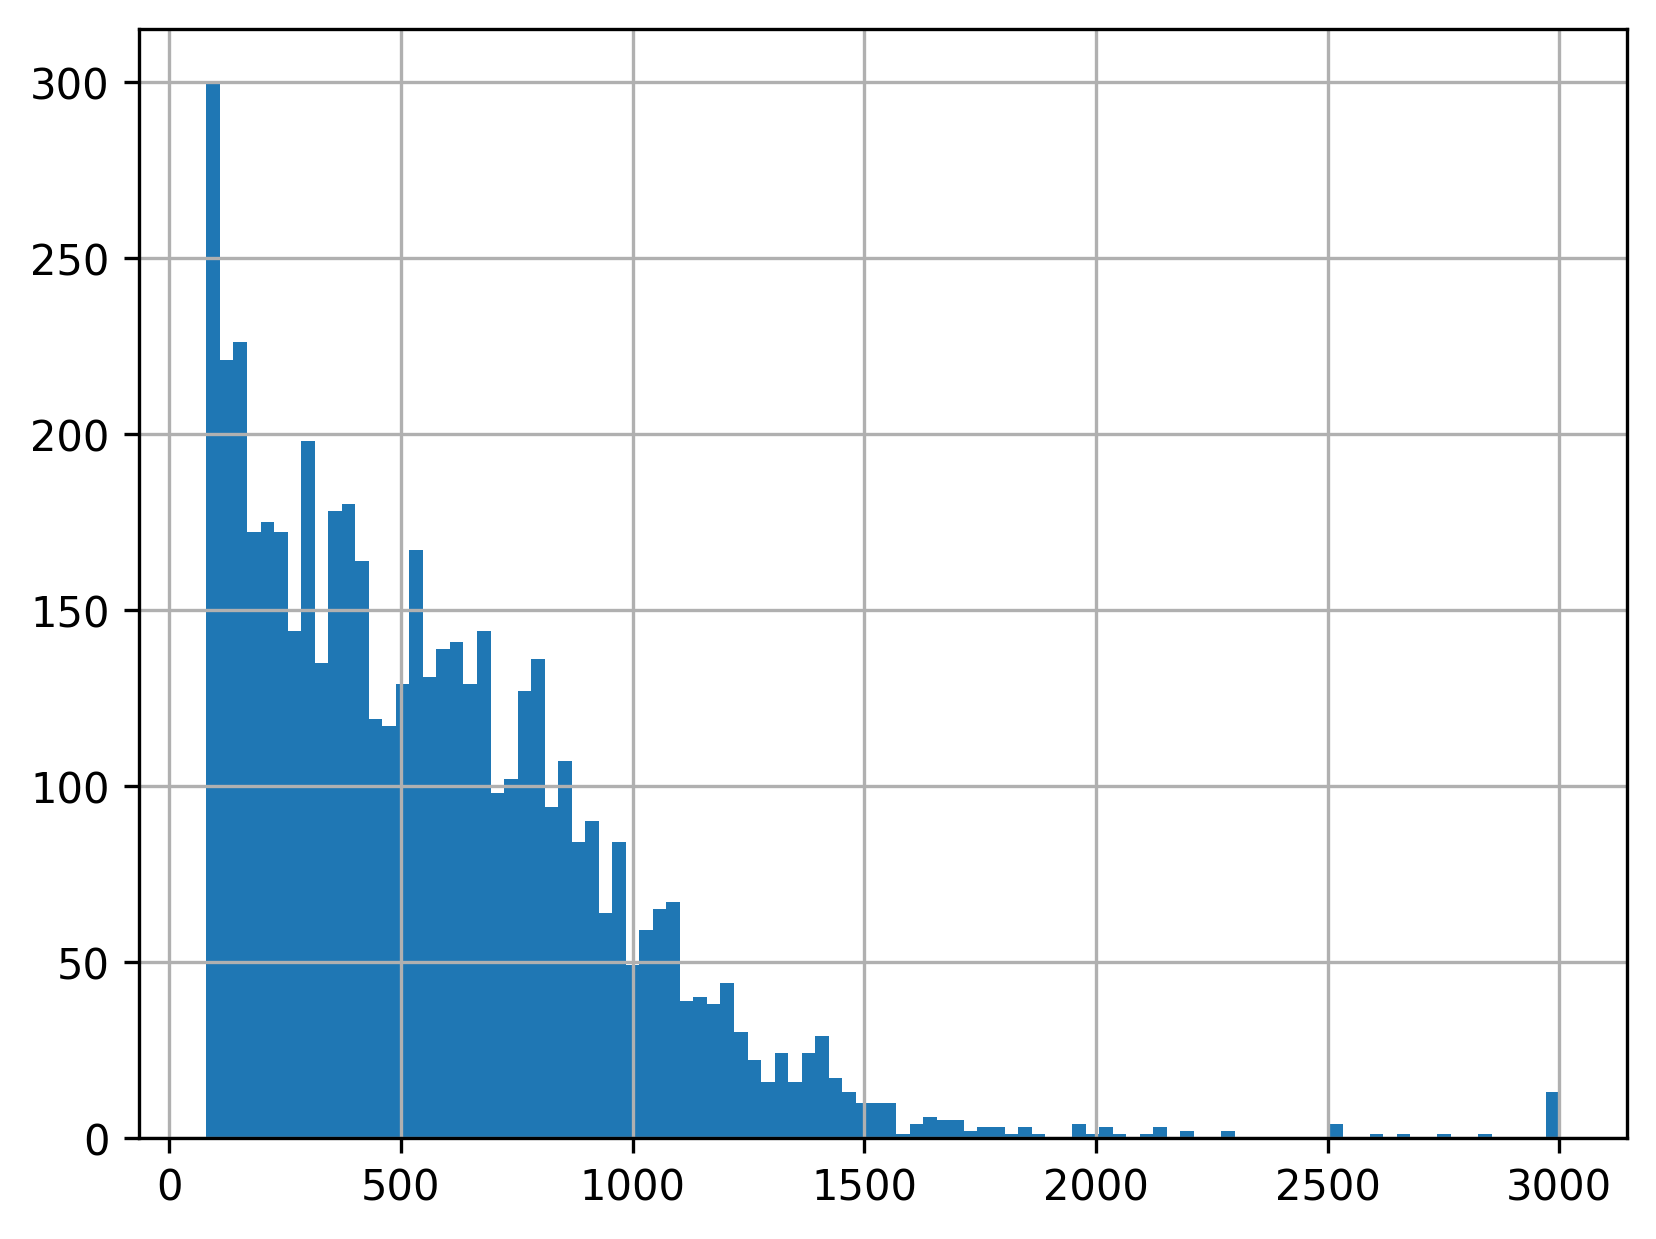

In [104]:
# Applying text preprocessing to actual data

df['title_desc_length'] = df['Title_Description'].apply(lambda x: len(x))
df = df[df['title_desc_length'] >= 80]
df['Title_Description'] = df['Title_Description'].apply(lambda x: x[:3000])
df['title_desc_length'] = df['Title_Description'].apply(lambda x: len(x))

df['title_desc_length'].hist(bins=100)
plt.show()

### 4. Text Embeddings

We use AllenAI/SPECTER, a model trained on scientific papers, which is well suited for research-related patent descriptions. Embeddings are cached to avoid expensive recomputation.

In [105]:
from sentence_transformers import SentenceTransformer
import json
import numpy as np
try:
    embeddings = np.load('embeddings.npy')
except:
    model = SentenceTransformer('sentence-transformers/allenai-specter')
    embeddings = model.encode(df['Title_Description'].to_list(), show_progress_bar=True)
    np.save('embeddings.npy',embeddings)


In [106]:
embeddings.shape

(5161, 768)

The model provides 768 dimensions, which will be prone to the 'curse of dimensionality'. For this reason, we should apply a dimensionality reduction.

### 5. Dimensionality Reduction and Clustering

Three approaches are compared: 

- **PCA** - fast and preserves global structure, more suited to linear data
- **t-SNE** - slower, good for local structure, non linear. More suited to visualisation
- **UMAP** - balanced, maintains more local and gloval structure, good for clustering

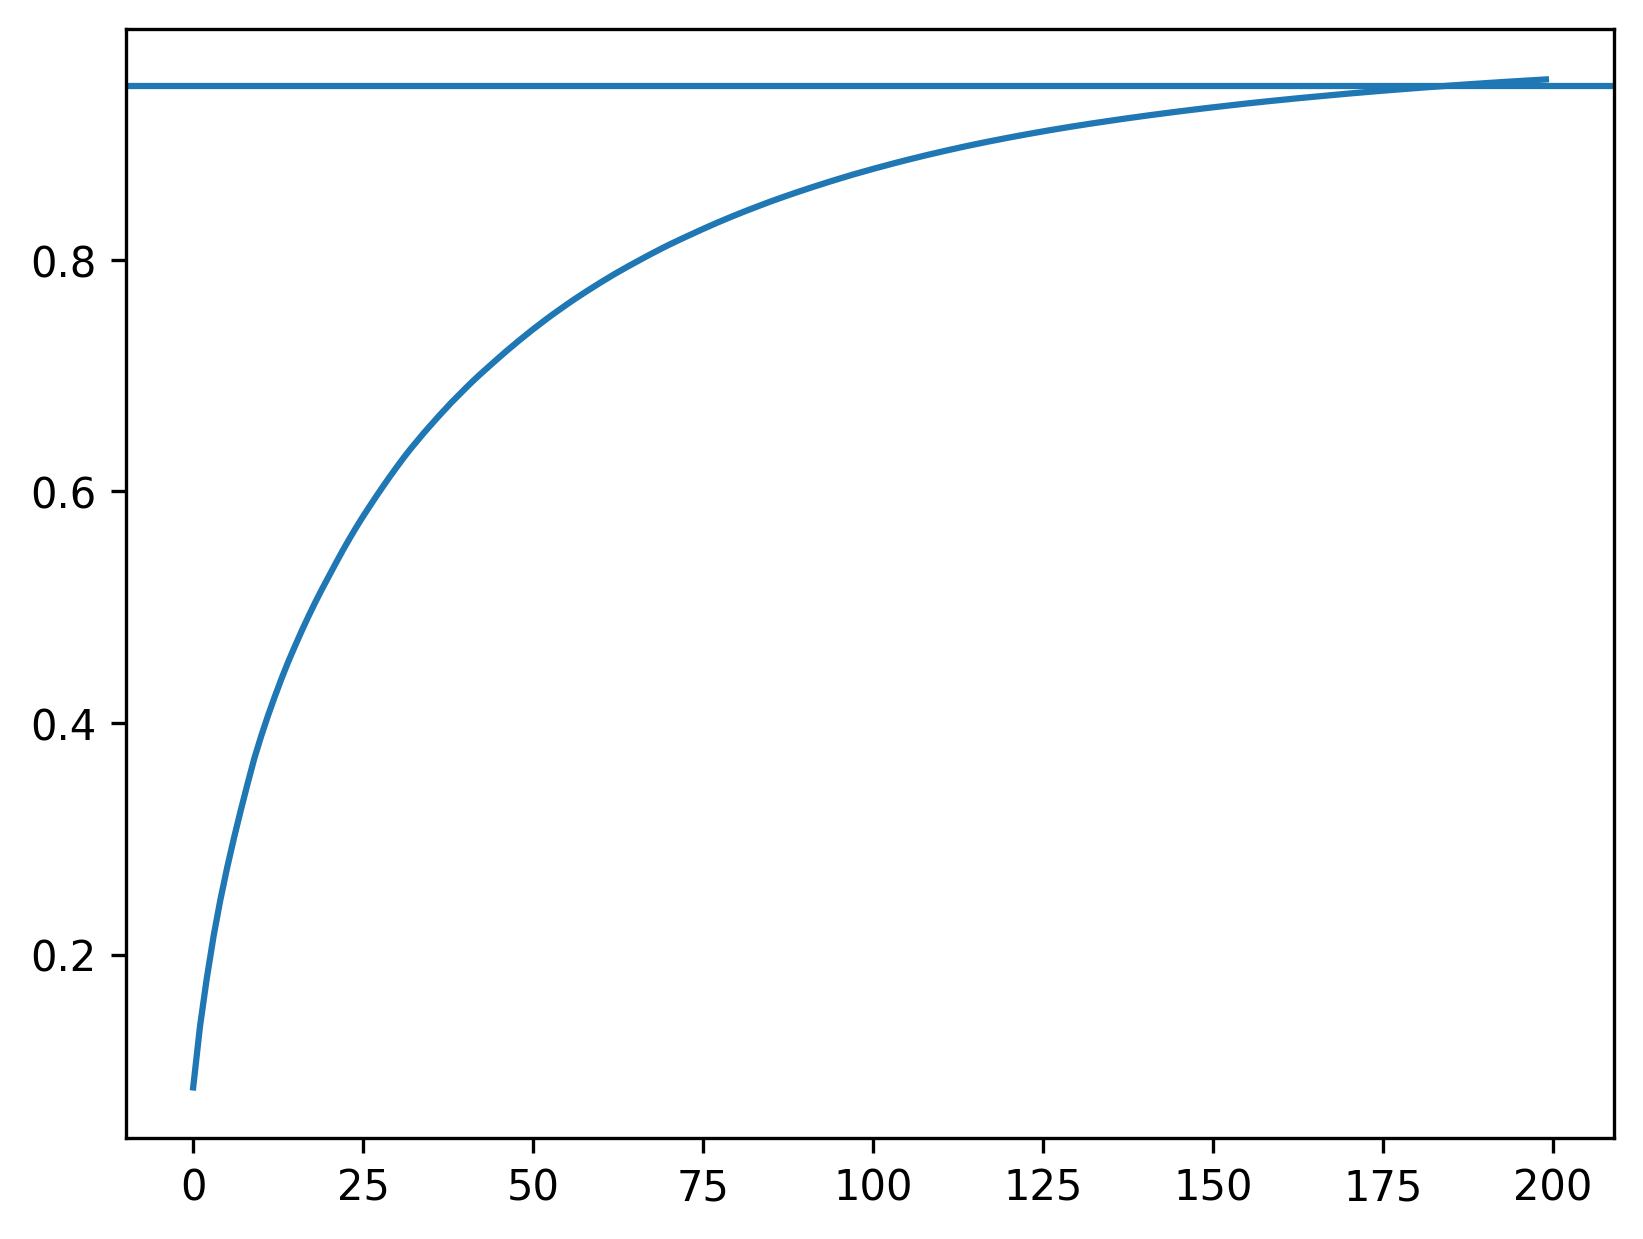

In [107]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=200)
reduced = pca.fit_transform(embeddings)
plt.plot(pca.explained_variance_ratio_.cumsum()) # Check how many dimensions are needed to maintain variance
plt.axhline(0.95) # Rough cut off point
plt.show()

We can check the mean and minimum standard deviations to ensure that each and every dimension is sufficiently useful:

In [108]:
print(f'Mean variance: {np.std(reduced, axis=0).mean():.2f}') 
print(f'Minimum variance: {np.std(reduced, axis=0).min():.2f}')  

Mean variance: 0.78
Minimum variance: 0.26


Now we can use k-means clustering with the PCA-reduced embeddings. Other clustering methods were attempted, such as DBSCAN and HDBSCAN, but the size of the dataset and these methods' rapidly scaling memory requirements led to the environment crashing

In [109]:
import plotly.express as px
from sklearn.cluster import MiniBatchKMeans

pca_visual = PCA(n_components=3)
reduced_pca2 = pca_visual.fit_transform(embeddings)

kmeans = MiniBatchKMeans(n_clusters=17, random_state=1, batch_size=256)
clusters = kmeans.fit_predict(reduced)

print(pd.Series(clusters).value_counts())
fig = px.scatter(x=reduced_pca2[:,0],y=reduced_pca2[:,1],color=clusters)
fig.show(config=config)

7     550
0     517
6     449
12    446
14    363
15    339
10    322
9     309
3     295
1     293
11    238
13    227
8     227
4     220
5     195
16    126
2      45
Name: count, dtype: int64


This shows that the k-means clustering algorithm has a generally good split between clusters. The visualisation shows some sense of clustering but it's difficult to see. We can plot these same clusters on a t-SNE visualisation to see it more clearly.

In [110]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
reduced_tsne = tsne.fit_transform(embeddings)

# Using t-SNE-reduced data is generally not recommended for clustering

kmeans_tsne = MiniBatchKMeans(n_clusters=17, random_state=1, batch_size=256) 
clusters_tsne = kmeans_tsne.fit_predict(reduced_tsne)


Now we can plot the clustering results from the PCA method on the t-SNE dimensions:

In [111]:
fig = px.scatter(x=reduced_tsne[:,0],y=reduced_tsne[:,1],color=clusters)
fig.show(config=config)

For reference, this is how t-SNE clusters the data:

In [112]:
fig = px.scatter(x=reduced_tsne[:,0],y=reduced_tsne[:,1],color=clusters_tsne)
fig.show(config=config)

Now we can try UMAP which is suitable for both visualisation and clustering:

In [113]:
import umap

reducer = umap.UMAP()

kmeans_umap = MiniBatchKMeans(n_clusters=17, random_state=1, batch_size=256)
reduced_umap = reducer.fit_transform(embeddings)

clusters_umap = kmeans_umap.fit_predict(reduced_umap)

fig = px.scatter(x=reduced_umap[:,0],y=reduced_umap[:,1],color=clusters_umap, title='UMAP cluster projection of UKRI-funded patent data ')
fig.show(config=config)

There are some very distinct outliers, which may point towards datapoints with noisy descriptions (conveying no real information)

### 6. Silhouette Score

The Silhouette score is a useful metric for assessing the quality of clustering data. A higher score means better clustering.

In [114]:
from sklearn.metrics import silhouette_score

pca_score = silhouette_score(reduced,clusters)
umap_score = silhouette_score(reduced_umap,clusters_umap)
tsne_score = silhouette_score(reduced_tsne,clusters_tsne)
print(f'PCA: {pca_score:.2f}')
print(f'UMAP: {umap_score:.2f}')
print(f't-SNE: {tsne_score:.2f}')

PCA: 0.05
UMAP: 0.38
t-SNE: 0.35


UMAP achieved the highest silhouette score, indicating that points are most associated with their clusters.

In [115]:
# Free up memory by removing large embeddings array
try:
    del embeddings
    gc.collect()
except:
    pass

In [116]:
df['cluster'] = clusters_umap

### 7. Cluster Analysis

Now let's visualise the split between the clusters, in particular if the clusters show variation between accepted and rejected patents:

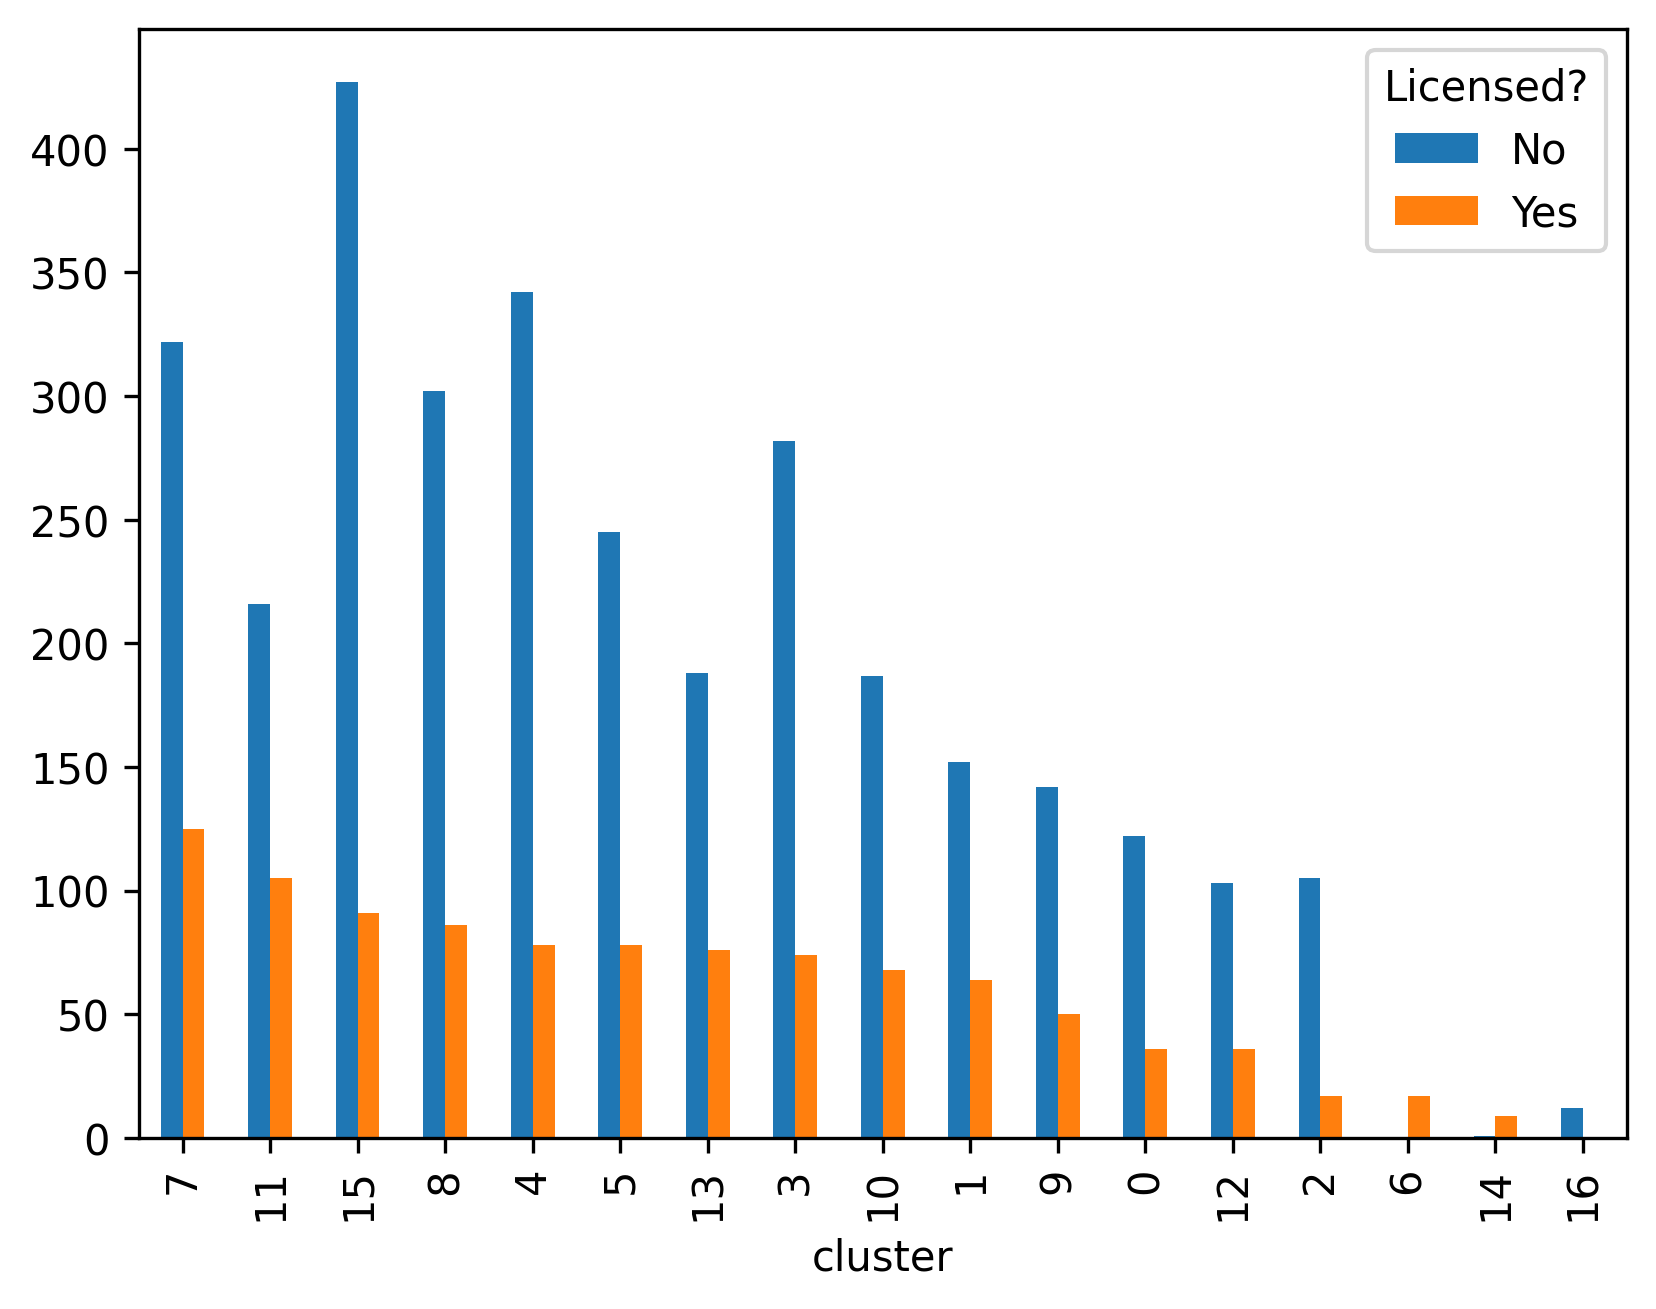

1854    MICROFLUIDIC ABSORPTION CELL: An absorption ce...
6283    Apparatus and Method: The present invention re...
104     MASS TRANSFER PROCESSES WITH LIMITED SENSIBLE ...
4314    CONTINUUM MANIPULATOR: Embodiments of the pres...
5087    Syringe mixing devices: WIPO Hague registratio...
3566    METABOLITE DETECTION APPARATUS AND CORRESPONDI...
3984    MEASUREMENT OF CAPILLARY REFILL TIME: A device...
912     Pulsed pumping for subsurface engineering: Res...
504     A joint: A bendable portion, also called a fle...
1305    Auto-sampler device and method of autosampling...
5981    A ROBOTIC DEVICE: The present invention provid...
3916    PARTICLE SEPARATION SYSTEMS AND METHODS: The i...
6272    BIOMOLECULAR STRUCTURE DETERMINATION INVOLVING...
5962    A HEAT PUMP SYSTEM: A heat pump system for con...
2879    A DEVICE: A surgical device (204) comprising a...
1553    Heat exchange apparatus: The invention relates...
4715    Pump and valve: New components of microfluidic...
1227    METHOD

In [117]:
cluster_patents= df.groupby('cluster')['Licensed?'].value_counts().unstack()
cluster_patents['Total'] = cluster_patents.sum(axis=1)
cluster_patents_ordered = cluster_patents.sort_values('Yes',ascending=False)

cluster_patents_ordered[['No','Yes']].plot(kind='bar')
plt.show()
for i in range(0,5):
    print(df[df['cluster'] == cluster_patents_ordered.index[i]]['Title_Description'].sample(20))
    print()

The cursory glance at each cluster above shows trends within (biotech, formulation, signal processing, etc.) We can also check if a cluster contains patents from similar departments:

In [118]:
df[df['cluster'] == 1]['Department'].value_counts()

Department
UNLISTED                                    73
Mechanical Engineering                      35
The Roslin Institute                        14
College of Medical, Veterinary, Life Sci     7
Chemistry                                    7
                                            ..
Nanotechnology and Adv Materials Inst        1
Oxford Physics                               1
Inst of Pharmacy and Biomedical Sci          1
Sch of Engineering Design and Technology     1
Centre for Clinical Brain Sciences           1
Name: count, Length: 74, dtype: int64

It is surprising to see patents from Mathematics here, so we should sanity check these:

In [119]:
df[(df['cluster'] == 1) & (df['Department'] == 'Mathematics')]['Title_Description'].values

<StringArray>
[]
Length: 0, dtype: str

Interestingly, these patents have been correctly categorised. This, as well as the fact that the 'Department' == 'UNLISTED' patents have been categorised, shows that additional information has been extracted through this clustering method.

### 8. Automated Cluster Labelling

Now we can use an LLM (via the Hugging Face inference API) to generative descriptive labels for each cluster. a random sample (n=20) is taken from each cluster to generate a message to pass to an LLM.

In [120]:
def get_chat_message(cluster,df:pd.DataFrame):
    cluster_df = df[df['cluster'] == cluster]
    sample = cluster_df.sample(20,random_state=42,replace=True)
    desc_strings = sample['Title_Description'].values
    desc_string = '--- '

    for desc in desc_strings:
        desc_string = desc_string + desc + ' --- '
    chat_request = f'Here are 20 research-related patent descriptions from a cluster, separated by ---. What exact patent field unifies the majority of them? Reply with 2-3 words only. {desc_string}'

    return chat_request


chat_messages = {}
clusters = len(df['cluster'].unique())
for i in range(0,clusters):
    cluster_message = get_chat_message(i,df)
    chat_messages[i] = cluster_message
chat_messages

{0: 'Here are 20 research-related patent descriptions from a cluster, separated by ---. What exact patent field unifies the majority of them? Reply with 2-3 words only. --- MEASUREMENT OF ACCELERATION: An acceleration measuring device is disclosed, for use as a gravimeter or gradiometer for example. The device has a support and a proof mass, connected to each other by at flexures allowing displacement of the proof mass relative to the support. The support defines a space for displacement of the proof mass. The device is configured so that the modulus of the gradient of the force-displacement curve of the proof mass decreases with increasing displacement, for at least part of the force-displacement curve. This is the so-called anti-spring effect. The resonant frequency of oscillation of the proof mass is determined at least in part by the orientation of the device relative to the direction of the force due to gravity. The proof mass is capable of oscillating with a resonant frequency of

In [121]:
import time
from huggingface_hub import InferenceClient
import os
from dotenv import load_dotenv
load_dotenv()

# Check if .csv already exists to avoid redundant LLM requests
if os.path.exists('ukri.csv'): 
    df = pd.read_csv('ukri.csv')
    print(df['cluster_category'].value_counts())
else:
    #Initiate HF client
    client = InferenceClient(token=os.environ.get('HF_TOKEN'))

    # Send chat responses to LLM
    chat_responses = {}
    for cluster, chat_message in chat_messages.items():
        response = client.chat_completion(
        model='openai/gpt-oss-120b',
        messages=[
            {'role':'user','content':chat_message}
        ]
        )
        chat_responses[cluster] = response.choices[0].message.content
        time.sleep(0.2)
    
    df['cluster_category'] = df['cluster'].map(chat_responses)
    df.to_csv('ukri.csv')



cluster_category
Nucleic acid technologies      563
Computer Vision                518
Energy Materials               495
Optical sensing                480
Medical devices                464
Photonic devices               441
Semiconductor devices          419
Regenerative Medicine          374
Pharmaceutical therapeutics    364
Immunotherapy patents          288
Detergent enzymes              238
Water sensing                  219
Plant biotechnology            202
Plant disease resistance        39
Avian biotechnology             22
Biosensor technology            18
Fuel cells                      17
Name: count, dtype: int64


There are no duplicate fields, suggesting that the clusters are sufficiently distinct. We can sample from the top category to see that they match the label:

In [122]:
df[df['cluster_category'] == 'Nucleic acid technologies']['Title_Description'].sample(20)

3878    METHODS FOR DIAGNOSING MOTOR NEURON DISEASES: ...
312     A METHOD OF PREDICTING ONE OR MORE NEURO-DEVEL...
14      DNA DAMAGE TESTING: The invention relates to a...
4064    METHODS FOR ASSESSING MACULAR DEGENERATION: Me...
1261    Oligosaccharyltransferase Polypeptide: New enz...
899     TRIPHOSPHORYLATION REACTION: The disclosure pr...
2241    A method of diagnosing, prognosing and/or moni...
322     METHOD OF GLYCOSLYATED PROTEIN PRODUCTION IN A...
3570    A NEW BIOMARKER FOR PREECLAMPSIA: This inventi...
1441    BIOMARKER AND USES THEREOF: A method of determ...
2478    METHOD FOR PREDICTING CERVICAL SHORTENING AND ...
3369    VECTOR: The present invention now provides a c...
336     INSULIN-LIKE GROWTH FACTOR INHIBITOR AND CHEMO...
4643    TREATMENT FOR DEMYELINATING DISEASE: This inve...
485     Advanced CART treatment of prostate cancer: 5t...
665     DETECTION OF LIPID MARKERS: The present invent...
3126    A METHOD FOR THE ISOLATION OF DOUBLE-STRAND BR...
3070    ASSAY 

### 9. Results: Patents by Research Domain

<Axes: ylabel='cluster_category'>

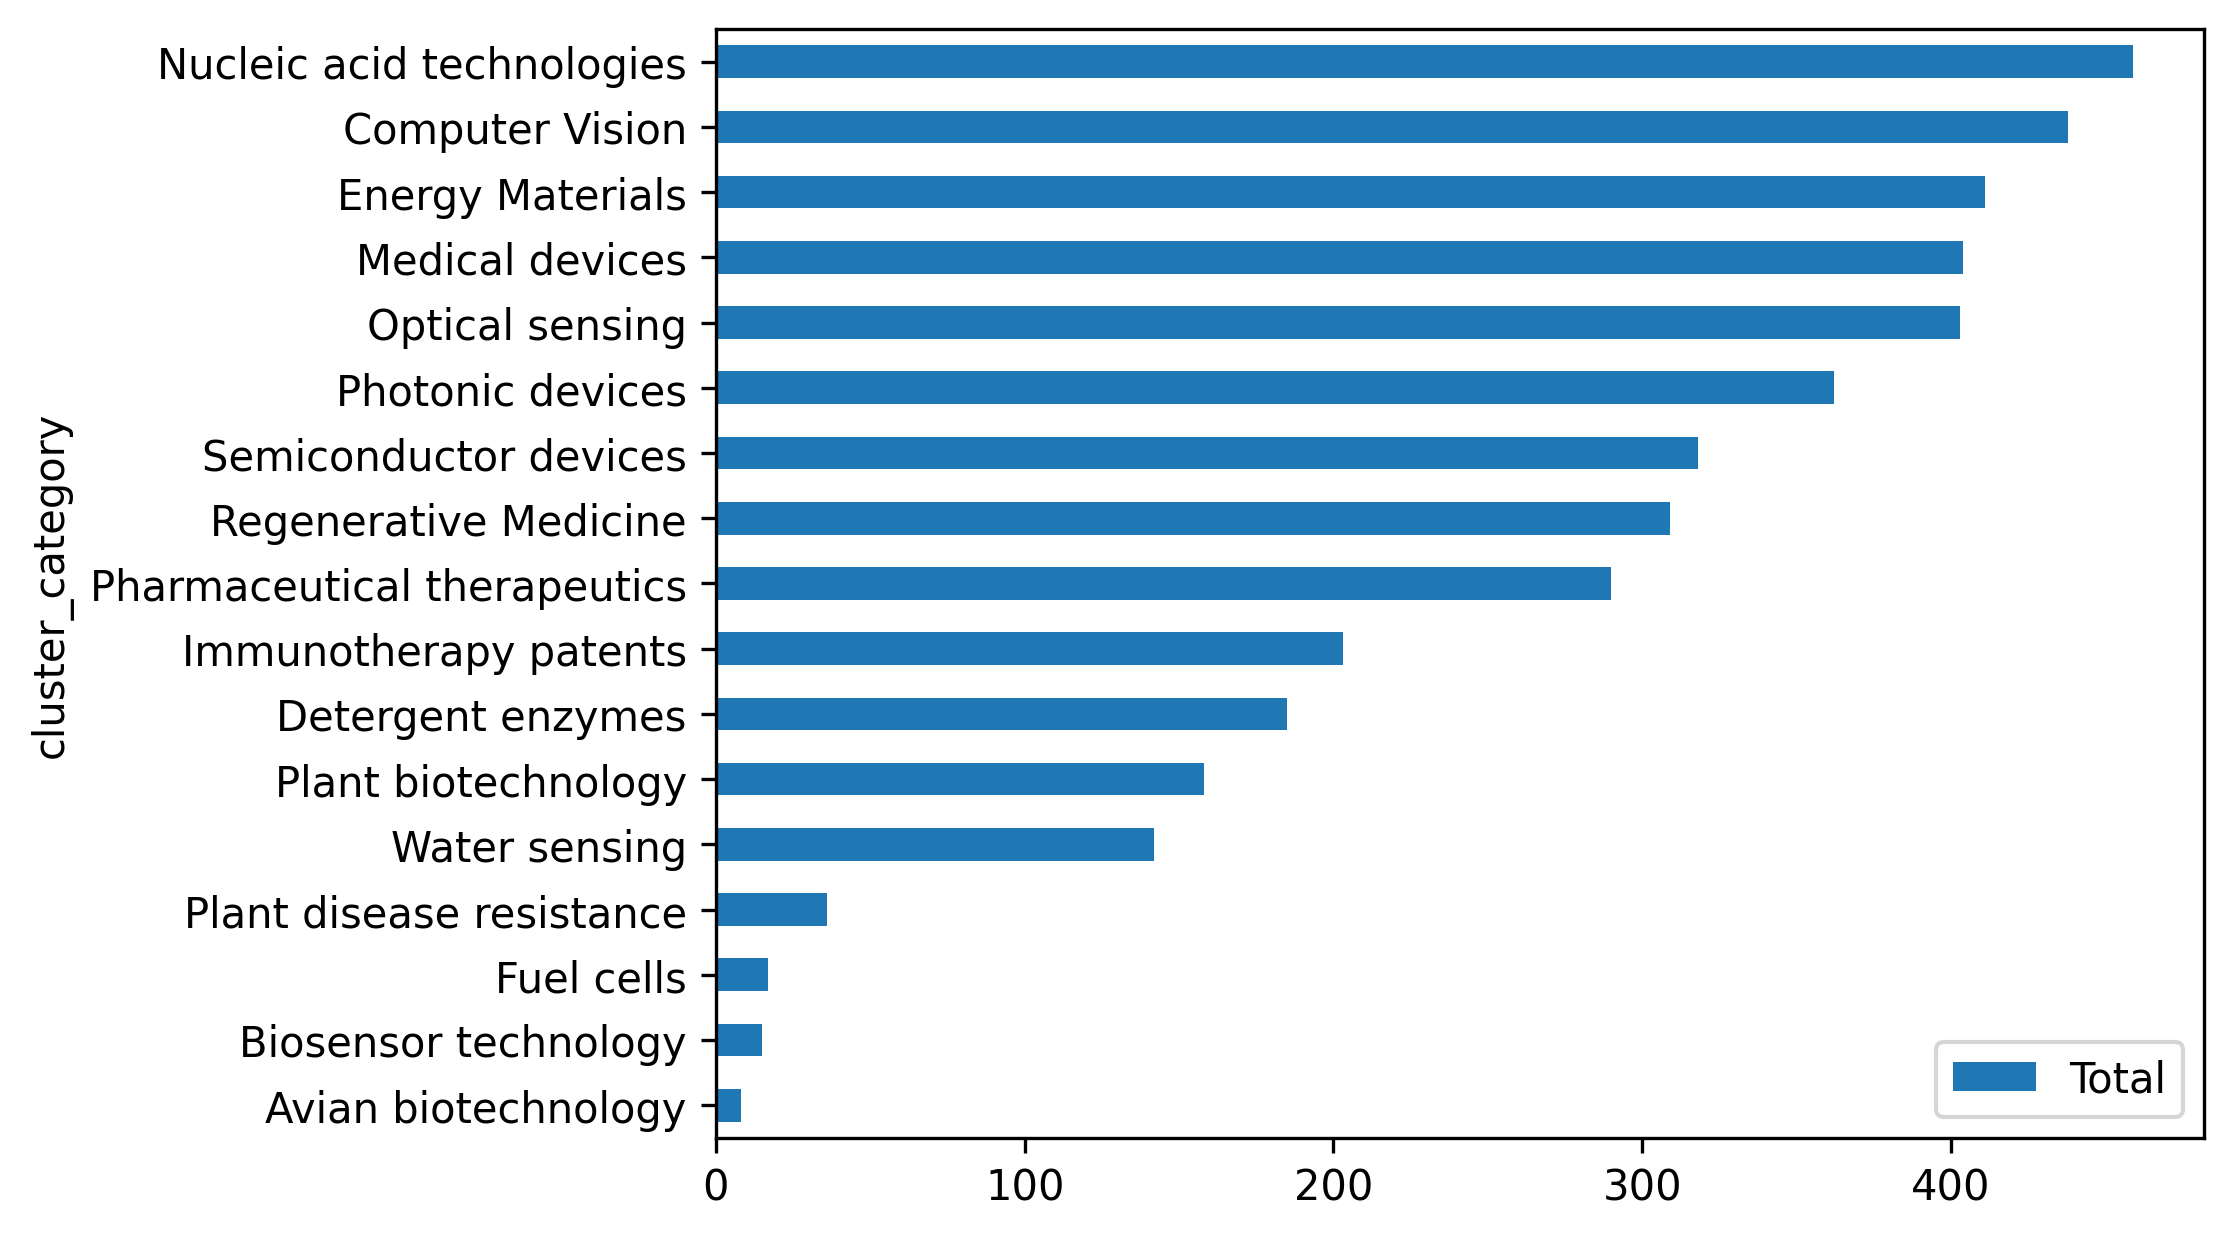

In [123]:
cluster_groups = df.groupby('cluster_category')['Licensed?'].value_counts().unstack()
cluster_groups = cluster_groups.fillna(0).sort_values('Yes').drop('Commercial In Confidence',axis=1)
cluster_groups['Total'] = cluster_groups['Yes'] + cluster_groups['No']
cluster_groups.sort_values('Total').plot(y='Total',kind=('barh'))

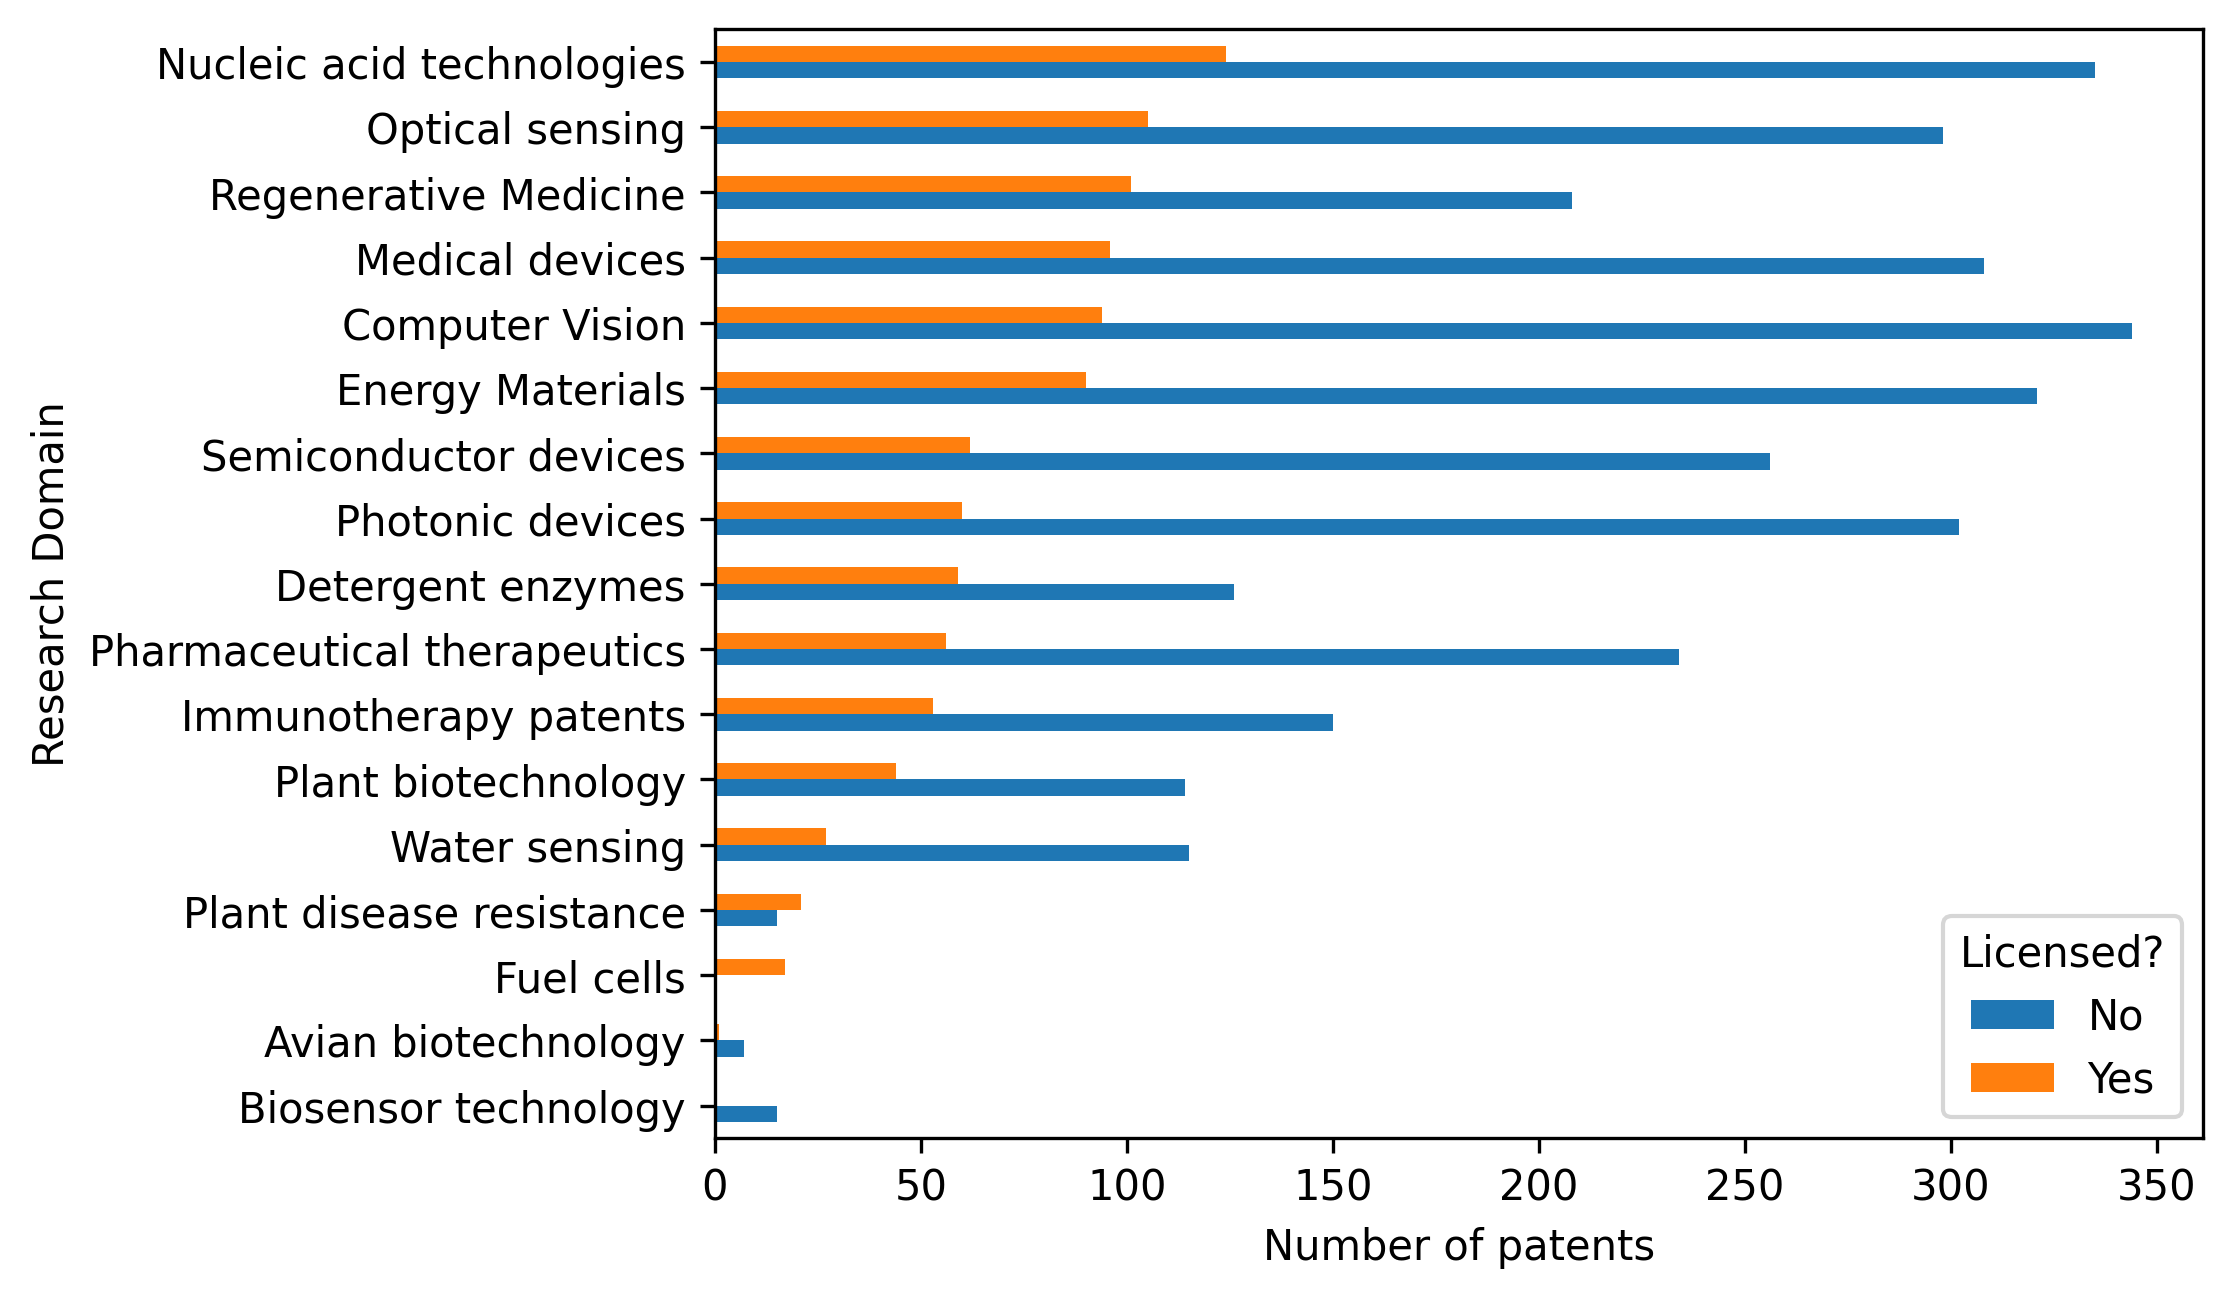

In [124]:
cluster_groups = df.groupby('cluster_category')['Licensed?'].value_counts().unstack()
cluster_groups = cluster_groups.fillna(0).sort_values('Yes').drop('Commercial In Confidence',axis=1)
cluster_groups.plot(kind='barh')
plt.xlabel('Number of patents')
plt.ylabel('Research Domain')
plt.show()

Licensed?                       No    Yes  Total  Yes_percent  No_percent
cluster_category                                                         
Nucleic acid technologies    335.0  124.0  459.0     0.270153    0.729847
Computer Vision              344.0   94.0  438.0     0.214612    0.785388
Energy Materials             321.0   90.0  411.0     0.218978    0.781022
Medical devices              308.0   96.0  404.0     0.237624    0.762376
Optical sensing              298.0  105.0  403.0     0.260546    0.739454
Photonic devices             302.0   60.0  362.0     0.165746    0.834254
Semiconductor devices        256.0   62.0  318.0     0.194969    0.805031
Regenerative Medicine        208.0  101.0  309.0     0.326861    0.673139
Pharmaceutical therapeutics  234.0   56.0  290.0     0.193103    0.806897
Immunotherapy patents        150.0   53.0  203.0     0.261084    0.738916
Detergent enzymes            126.0   59.0  185.0     0.318919    0.681081
Plant biotechnology          114.0   4

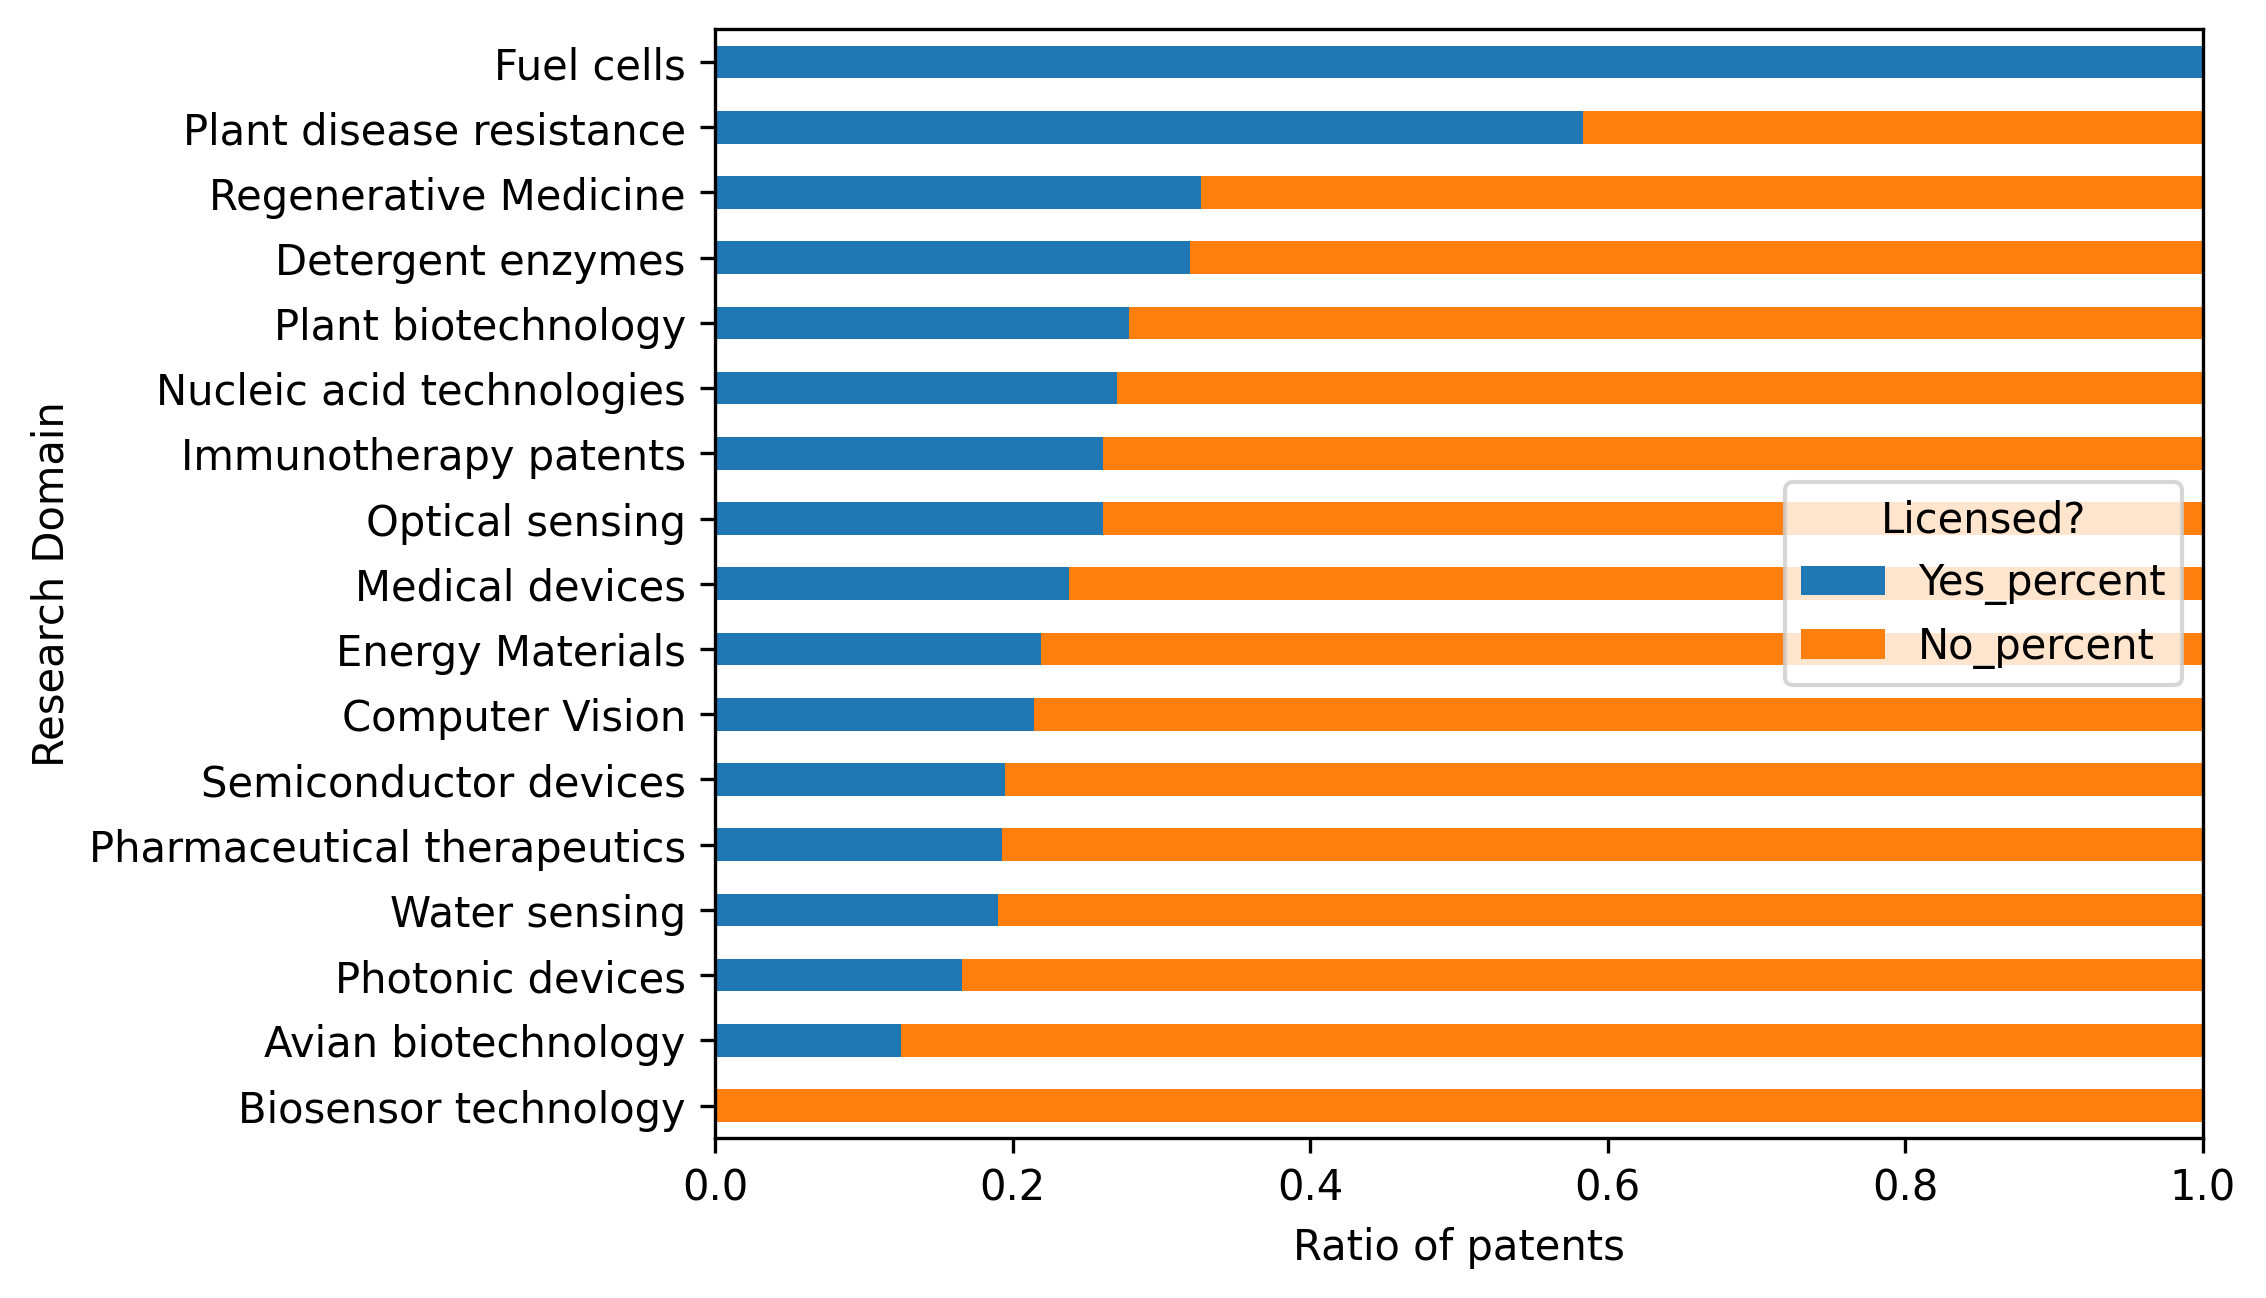

In [125]:
cluster_groups['Total'] = cluster_groups['Yes'] + cluster_groups['No']
cluster_groups['Yes_percent'] = cluster_groups['Yes']/cluster_groups['Total']
cluster_groups['No_percent'] = cluster_groups['No']/cluster_groups['Total']
cluster_groups = cluster_groups.sort_values('Yes_percent',ascending=True)
cluster_groups[['Yes_percent','No_percent']].plot(kind='barh',stacked=True)
print(cluster_groups.sort_values('Total',ascending=False))
plt.xlabel('Ratio of patents')
plt.ylabel('Research Domain')
plt.show()

In [126]:
df.head()

,Unnamed: 0,Funding OrgName,Project Reference,ProjectCategory,Outcome Type,LeadRO Name,Department,PI Surname,PI First Name,PI Orcid iD,...,GTRProjectUrl,ProjectId,FundingOrgId,LeadROId,PIId,PI Name,Title_Description,title_desc_length,cluster,cluster_category
0,1,EPSRC,EP/N022793/1,Research Grant,Intellectual Property,University of Bath,Chemistry,Buchard,Antoine,http://orcid.org/0000-0003-3417-5194,...,http://gtr.ukri.org/projects?ref=EP/N022793/1,0FFD0DA6-3142-4464-9D1F-00A8575F8C04,798CB33D-C79E-4578-83F2-72606407192C,5A199D1E-A580-4E50-8F18-A1C8CF2F85D6,6192559B-E9FC-41B4-9F67-B08C7773E51C,Antoine Buchard,POLYMERISATION PROCESSES: A polymerisation pro...,765,4,Detergent enzymes
1,2,MRC,MC_PC_18053,Intramural,Intellectual Property,University of Leeds,UNLISTED,Philippou,Helen,NaN,...,http://gtr.ukri.org/projects?ref=MC_PC_18053,0E38D2AD-A758-47BB-B0F8-0106B23E00DA,C008C651-F5B0-4859-A334-5F574AB6B57C,CA799973-1F1B-4936-B99A-9970F567FE67,0A06E3CD-8792-4320-BDAB-6A158CA7A519,Helen Philippou,TRPC ION CHANNEL INHIBITORS FOR USE IN THERAPY...,548,14,Pharmaceutical therapeutics
2,3,EPSRC,EP/M006360/1,Fellowship,Intellectual Property,University of Cambridge,Physics,Rao,Akshay,NaN,...,http://gtr.ukri.org/projects?ref=EP/M006360/1,243F4A8E-DDBE-430F-85B9-00CEC73F1066,798CB33D-C79E-4578-83F2-72606407192C,3B084C44-5AC4-43B5-AE31-F7DA58683C5C,28582531-AB5E-449F-B824-BA9D58CF9092,Akshay Rao,COMPOSITE LIGHT HARVESTING MATERIAL AND DEVICE...,847,5,Semiconductor devices
3,4,STFC,ST/K002937/1,Research Grant,Intellectual Property,University of Edinburgh,Sch of Physics and Astronomy,Watts,Daniel,NaN,...,http://gtr.ukri.org/projects?ref=ST/K002937/1,26FE0BB4-68C7-4E7B-87D0-015F46E96693,D7F4F462-0518-4784-908A-D12633C139B3,A4735E0B-ED6E-4FC5-9497-CFE564317F54,F55110B4-C545-4D29-ADE6-638AD0E7C2A3,Daniel Watts,"A METHOD OF, AND APPARATUS FOR, PROCESSING POS...",1391,7,Computer Vision
4,6,EPSRC,EP/N013514/1,Research Grant,Intellectual Property,University of Oxford,Oxford Chemistry,Vincent,Kylie,http://orcid.org/0000-0001-6444-9382,...,http://gtr.ukri.org/projects?ref=EP/N013514/1,439D6A89-9568-4E95-B961-0014D4A4CB35,798CB33D-C79E-4578-83F2-72606407192C,47649064-FCD1-4D7A-A5AA-31B69B9BDFFC,D147351F-DBCC-46C7-B9F1-202C3761D432,Kylie Vincent,METHOD FOR PRODUCING A DEUTERATED OR TRITIATED...,486,14,Pharmaceutical therapeutics


## Conclusions

### Key Findings

- **Nucleic acid technologies**, **Computer Vision**, and **Energy Materials** see the highest number of patents applied for, at over **310 each**

- Amongst the top five most patented fields, **Regenerative Medicine** sees the highest success rate with ~35% of patents being accepted

- The majority of patents are funded by **EPSRC**, **BBSRC,** or **MRC**

### Limitations

- Cluster labels are LLM-generated from a sample of only 20 patents each

- Licensing status reflects commercialisation, not necessarily impact or quality

- Clustering performance could be improved, either by further preprocessing or trying different transformer models
